In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time
path="D:\Python\Elo"
df_train = pd.read_csv(os.path.join(path,'train.csv'))
#df_test = pd.read_csv(os.path.join(path,'test.csv'))
df_hist = pd.read_csv(os.path.join(path,'historical_transactions.csv'))
df_new = pd.read_csv(os.path.join(path,'new_merchant_transactions.csv'))
df_merch=pd.read_csv(os.path.join(path,'merchants.csv'))

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
df_train=reduce_mem_usage(df_train)
df_merch=reduce_mem_usage(df_merch)
df_hist=reduce_mem_usage(df_hist)
df_new=reduce_mem_usage(df_new)


Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to 30.32 Mb (46.0% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)
Wall time: 1min 18s


In [3]:
%%time
def preprocessing(df):
    df['avg_sales_lag3'].fillna(0,inplace=True)
    df['avg_sales_lag6'].fillna(0,inplace=True)
    df['avg_sales_lag12'].fillna(0,inplace=True)
    df['category_2'].fillna(1,inplace=True)
    return df
df_merch=preprocessing(df_merch)
df_merch=df_merch.rename(columns={'numerical_1':'merch_numerical_1','numerical_2':'merch_numerical_2','category_1':'merch_category_1',
                        'category_2':'merch_category_2','category_4':'merch_category_4','active_months_lag12':'merch_active_months_lag12',
                        'avg_purchases_lag3':'merch_avg_purchases_lag3','most_recent_sales_range':'merch_most_recent_sales_range',
                         'avg_sales_lag3':'merch_avg_sales_lag3','most_recent_purchases_range':'merch_most_recent_purchases_range'})
df_merch=df_merch[['merchant_id','merch_numerical_1','merch_numerical_2','merch_category_1','merch_category_2',
                  'merch_category_4','merch_active_months_lag12','merch_avg_purchases_lag3','merch_most_recent_sales_range',
                  'merch_avg_sales_lag3','merch_most_recent_purchases_range']]
df_hist=df_hist.merge(df_merch,how='left',on='merchant_id')
df_new=df_new.merge(df_merch,how='left',on='merchant_id')

Wall time: 52.3 s


In [4]:
%%time
def preprocessing(df):
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    df['installments'].replace(-1, np.nan,inplace=True)
    df['installments'].replace(999, np.nan,inplace=True)
    return df
def new_data(df):
    for col in ['category_2','category_3']:
        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        df[col+'_min'] = df.groupby([col])['purchase_amount'].transform('min')
        df[col+'_max'] = df.groupby([col])['purchase_amount'].transform('max')
        df[col+'_sum'] = df.groupby([col])['purchase_amount'].transform('sum')
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['day'] = df['purchase_date'].dt.day
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['weekday'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(np.int32)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df['duration'] = df['purchase_amount']*df['month_diff']
    df['amount_month_ratio'] = df['purchase_amount']/df['month_diff']
    df['amount_month_ratio'] = df['purchase_amount']/df['month_diff']
    df['ratio_purchase_sales']=df['merch_avg_purchases_lag3']/df['merch_avg_sales_lag3']
    df['price'] = df['purchase_amount'] / df['installments']
    df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25')-df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Mothers Day: May 14 2017
    df['Mothers_Day_2017']=(pd.to_datetime('2017-06-04')-df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #fathers day: August 13 2017
    df['fathers_day_2017']=(pd.to_datetime('2017-08-13')-df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Childrens day: October 12 2017
    df['Children_day_2017']=(pd.to_datetime('2017-10-12')-df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Valentine's Day : 12th June, 2017
    df['Valentine_Day_2017']=(pd.to_datetime('2017-06-12')-df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Black Friday : 24th November 2017
    df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Mothers Day: May 13 2018
    df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13')-df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    df['category_22']=df['category_2']
    df['category_33']=df['category_3']
    df=pd.get_dummies(df, columns=['category_2', 'category_3'])
    return df
df_hist=new_data(preprocessing(df_hist))
df_new=new_data(preprocessing(df_new))


Wall time: 17min 35s


In [7]:
%%time
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
def group_data(df,name='hist'):
    aggs={
    'merchant_id': ['nunique'],
    'day':['nunique','mean','min'],
    'weekday':['mean'],
    'weekend':['mean'],
    'month':['mean','nunique','min','max'],
    'weekofyear':['mean','nunique','min','max'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'merch_numerical_1':['mean','max', 'min'],
    'merch_numerical_2':['mean','max', 'min'],
    'merch_avg_purchases_lag3':['mean','max', 'min'],
    'merch_avg_sales_lag3':['mean','max', 'min'],
    'merch_active_months_lag12':['mean','max', 'min'],
    'ratio_purchase_sales':['mean','max', 'min'],
    'merch_category_1': ['nunique'],
    'merch_category_2': ['nunique'],
    'merch_category_4': ['nunique'],
    'merch_most_recent_sales_range':['nunique'],
    'merch_most_recent_purchases_range':['nunique'],
    'city_id': ['nunique'],
    'authorized_flag':['sum','mean']  ,  
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_date': ['min', 'max'],
    'month_lag': ['max','min','mean','var','skew'],
    'month_diff': ['mean'],
    'Christmas_Day_2017':['mean'],
    'Mothers_Day_2017':['mean'],
    'fathers_day_2017':['mean'],
    'Children_day_2017':['mean'],
    'Valentine_Day_2017':['mean'],
    'Black_Friday_2017':['mean'],
    'Mothers_Day_2018':['mean'],
    'category_1':['sum', 'mean'],
    'category_2_mean': ['mean'],
    'category_3_mean': ['mean'],
    'category_2_min': ['mean'],
    'category_3_min': ['mean'],
    'category_2_max': ['mean'],
    'category_3_max': ['mean'],
    'category_2_sum': ['mean'],
    'category_3_sum': ['mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'card_id':['size'],
    'price':['mean','min','max','var'],
    'duration':['mean','min','max','var','skew'],
    'amount_month_ratio':['mean','min','max','var','skew']
    }
    new_columns=get_new_columns(name,aggs)
    df=df.groupby(['card_id']).agg(aggs)
    df.columns=new_columns
    df.reset_index(drop=False,inplace=True)
    df[name+'_purchase_date_diff'] = (df[name+'_purchase_date_max'] - df[name+'_purchase_date_min']).dt.days
    df[name+'_purchase_date_average'] = df[name+'_purchase_date_diff']/df[name+'_card_id_size']
    df[name+'_purchase_date_uptonow'] = (datetime.datetime.today() - df[name+'_purchase_date_max']).dt.days
    df[name+'_purchase_date_downtonow'] = (datetime.datetime.today() - df[name+'_purchase_date_min']).dt.days
    return df
def null_add(df):
    df['add_merch_most_recent_sales_range_freq'].fillna('C',inplace=True)
    df['add_merch_most_recent_purchases_range_freq'].fillna('C',inplace=True)
    df['add_installments_freq'].fillna(0,inplace=True)
    df['add_merch_category_1_freq'].fillna('N',inplace=True)
    df['add_merch_category_2_freq'].fillna(1,inplace=True)
    df['add_merch_category_4_freq'].fillna('N',inplace=True)
    return df
df_hist_group=group_data(df_hist)
df_train=df_train.merge(df_hist_group,how='left',on='card_id')
add_hist_df=pd.read_csv(os.path.join(path,'additional_hist_data.csv'))
df_train=df_train.merge(add_hist_df,how='left',on='card_id')
del add_hist_df;
df_new_group=group_data(df_new,'new')
df_train=df_train.merge(df_new_group,how='left',on='card_id')
add_new_df=pd.read_csv(os.path.join(path,'additional_hist_data.csv'))
add_new_df=null_add(add_new_df)
df_train=df_train.merge(add_new_df,how='left',on='card_id')
del df_hist,df_new,add_new_df;

Wall time: 15min 23s


In [9]:
%%time
# def get_new_columns(name,aggs):
#     return [name + '_' + k + '_' + 'freq' for k in aggs.keys()]
# def frequency(data):
#     try:
#         freq=data.value_counts().index[0]
#     except IndexError:
#         freq=None
#     return freq
# def additional_data(df,name='hist'):
#     aggs={
#         'purchase_hour':[frequency],
#         'purchase_weekend':[frequency],
#         'merchant_category_id':[frequency],
#         'merch_most_recent_sales_range':[frequency],
#         'merch_most_recent_purchases_range':[frequency],
#         'city_id':[frequency],
#         'authorized_flag':[frequency],
#         'subsector_id':[frequency],
#         'installments':[frequency],
#         'purchase_month':[frequency],
#         'category_1':[frequency],
#         'merch_category_1':[frequency],
#         'merch_category_2':[frequency],
#         'merch_category_4':[frequency],
#         'category_22':[frequency],
#         'category_33':[frequency]
#     }
#     new_data=df.groupby(['card_id']).agg(aggs)
#     new_columns=get_new_columns('add',aggs)
#     new_data.columns=new_columns
#     return new_data
# add_hist_df=additional_data(df_hist)
# add_hist_df.to_csv(os.path.join(path,'additional_hist_data.csv'))
# add_new_df=additional_data(df_new,'new')
# add_new_df.to_csv(os.path.join(path,'additional_new_data.csv'))
# def null_add(df):
#     df['add_merch_most_recent_sales_range_freq'].fillna('C',inplace=True)
#     df['add_merch_most_recent_purchases_range_freq'].fillna('C',inplace=True)
#     df['add_installments_freq'].fillna(0,inplace=True)
#     df['add_merch_category_1_freq'].fillna('N',inplace=True)
#     df['add_merch_category_2_freq'].fillna(1,inplace=True)
#     df['add_merch_category_4_freq'].fillna('N',inplace=True)
#     return df
df_train.to_csv(os.path.join(path,'main.csv'))


Wall time: 1min


In [8]:
def last_preprocessing(df):
    df['first_active_month']=pd.to_datetime(df['first_active_month'])
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_last_buy'] = (df['new_purchase_date_max'] - df['first_active_month']).dt.days
    
    df=df.drop(['hist_purchase_date_min', 'hist_purchase_date_max', 'hist_purchase_date_min',
                'hist_purchase_date_max','new_purchase_date_min', 'new_purchase_date_max', 'new_purchase_date_min',
                'new_purchase_date_max'],axis=1)
    df['purchase_amount_total'] = df['new_purchase_amount_sum']+df['hist_purchase_amount_sum']
    
    df['quarter'] = df['first_active_month'].dt.quarter
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days

    df['days_feature1'] = df['elapsed_time'] * df['feature_1']
    df['days_feature2'] = df['elapsed_time'] * df['feature_2']
    df['days_feature3'] = df['elapsed_time'] * df['feature_3']

    df['days_feature1_ratio'] = df['feature_1'] / df['elapsed_time']
    df['days_feature2_ratio'] = df['feature_2'] / df['elapsed_time']
    df['days_feature3_ratio'] = df['feature_3'] / df['elapsed_time']
    
    df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
    df['feature_mean'] = df['feature_sum']/3
    df['feature_max'] = df[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
    df['feature_min'] = df[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
    df['feature_var'] = df[['feature_1', 'feature_2', 'feature_3']].std(axis=1)
    
    df['card_id_total'] = df['new_card_id_size']+df['hist_card_id_size']
    df['card_id_cnt_total'] = df['new_card_id_size']+df['hist_card_id_size']
    df['card_id_cnt_ratio'] = df['new_card_id_size']/df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_purchase_amount_mean']+df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_purchase_amount_max']+df['hist_purchase_amount_max']
    df['purchase_amount_min'] = df['new_purchase_amount_min']+df['hist_purchase_amount_min']
    df['purchase_amount_ratio'] = df['new_purchase_amount_sum']/df['hist_purchase_amount_sum']
    df['month_diff_mean'] = df['new_month_diff_mean']+df['hist_month_diff_mean']
    df['month_diff_ratio'] = df['new_month_diff_mean']/df['hist_month_diff_mean']
    df['month_lag_mean'] = df['new_month_lag_mean']+df['hist_month_lag_mean']
    df['month_lag_max'] = df['new_month_lag_max']+df['hist_month_lag_max']
    df['month_lag_min'] = df['new_month_lag_min']+df['hist_month_lag_min']
    df['category_1_mean'] = df['new_category_1_mean']+df['hist_category_1_mean']
    df['installments_total'] = df['new_installments_sum']+df['hist_installments_sum']
    df['installments_mean'] = df['new_installments_mean']+df['hist_installments_mean']
    df['installments_max'] = df['new_installments_max']+df['hist_installments_max']
    df['installments_ratio'] = df['new_installments_sum']/df['hist_installments_sum']
    df['price_total'] = df['purchase_amount_total'] / df['installments_total']
    df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
    df['price_max'] = df['purchase_amount_max'] / df['installments_max']
    df['duration_mean'] = df['new_duration_mean']+df['hist_duration_mean']
    df['duration_min'] = df['new_duration_min']+df['hist_duration_min']
    df['duration_max'] = df['new_duration_max']+df['hist_duration_max']
    df['amount_month_ratio_mean']=df['new_amount_month_ratio_mean']+df['hist_amount_month_ratio_mean']
    df['amount_month_ratio_min']=df['new_amount_month_ratio_min']+df['hist_amount_month_ratio_min']
    df['amount_month_ratio_max']=df['new_amount_month_ratio_max']+df['hist_amount_month_ratio_max']
    
    df['new_CLV'] = df['new_card_id_size'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
    df['hist_CLV'] = df['hist_card_id_size'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']
#    df['outliers'] = 0
#    df.loc[df['target'] < -30, 'outliers'] = 1
    return df
df_train=last_preprocessing(df_train)

In [ ]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
param = {'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**5),
                'bagging_seed':int(2**5),
                'drop_seed':int(2**5)}
rskf=StratifiedKFold(5,shuffle=True,random_state=4590)
val_pr=np.zeros(len(df_train))
feature_importance_df = pd.DataFrame()
#test_pr=np.zeros(len(df_test))
for train_index,val_index in rskf.split(df_train,df_train['outliers'].values):
    train_data=lgb.Dataset(df_train[df_train_columns].loc[train_index],label=df_train['target'].loc[train_index])
    val_data=lgb.Dataset(df_train[df_train_columns].loc[val_index],label=df_train['target'].loc[val_index])
    num_round = 10000
    model=lgb.train(param,train_data,num_round,valid_sets=[train_data,val_data],verbose_eval=100,early_stopping_rounds=200)
    fold_importance_df=pd.DataFrame()
    fold_importance_df['feature'] = df_train_columns
    fold_importance_df['importance']=model.feature_importance()
    feature_importance_df=pd.concat([feature_importance_df,fold_importance_df],axis=0)
    
    val_pr[val_index]=model.predict(df_train[df_train_columns].loc[val_index],num_iteration=model.best_iteration)
np.sqrt(mean_squared_error(val_pr,df_train['target']))

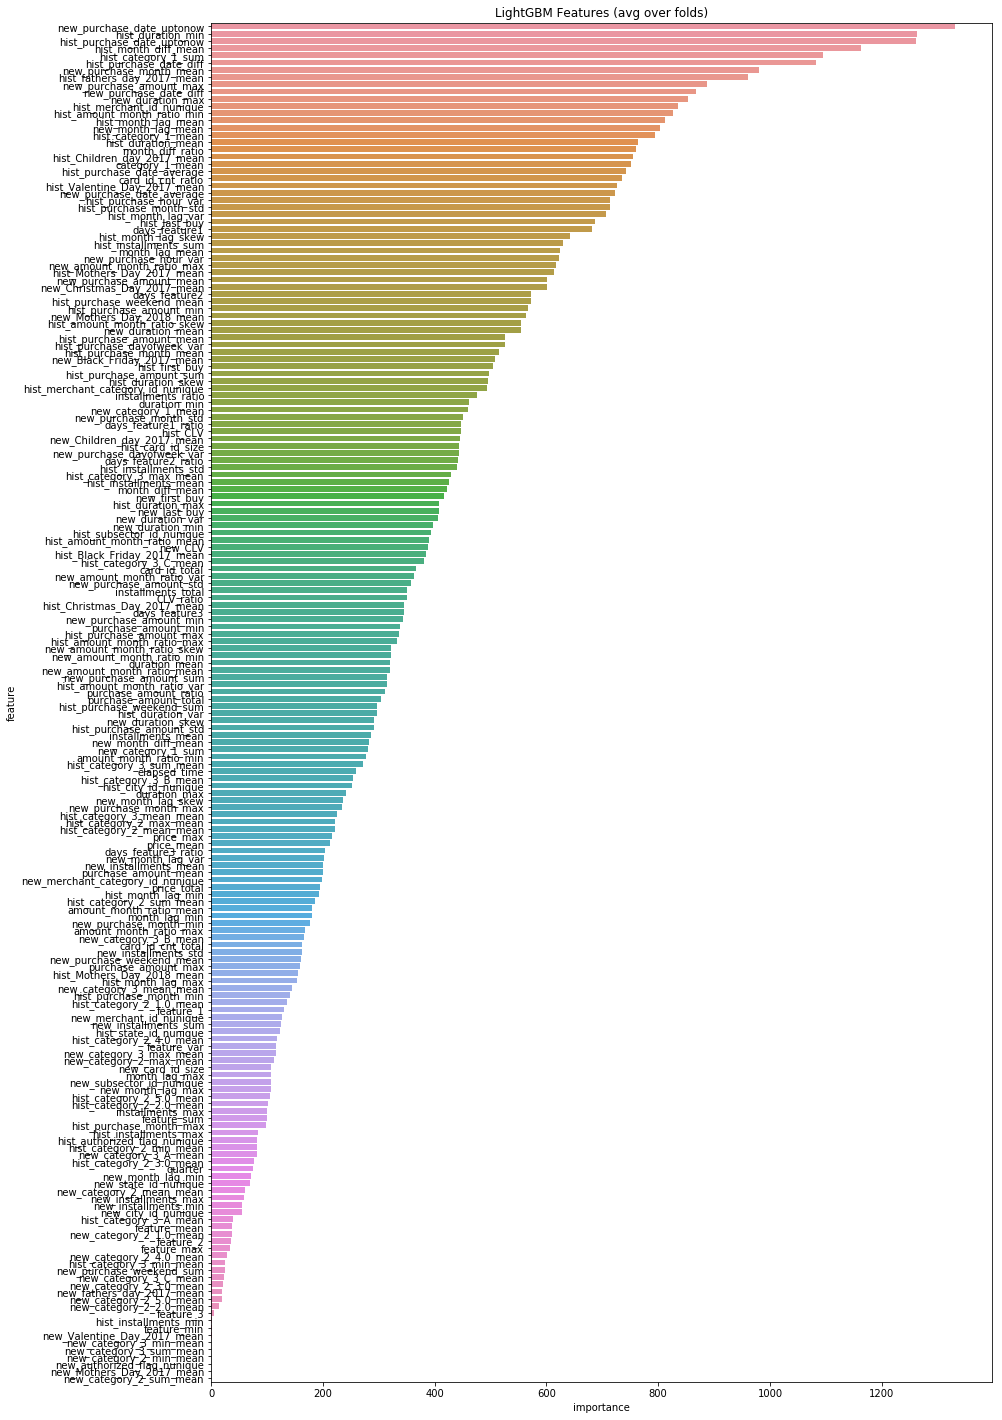

In [25]:
# first iteration 3.7205109380247072
# second iteration 3.6597031197728933
cols=(feature_importance_df.groupby('feature').mean().sort_values(by="importance", ascending=False))
cols.reset_index(drop=False,inplace=True)
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
           data=cols)
plt.title('LightGBM Features (avg over folds)')
plt.show()

In [38]:
from catboost import CatBoostClassifier, Pool
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
param = {'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**5),
                'bagging_seed':int(2**5),
                'drop_seed':int(2**5)}
rskf=StratifiedKFold(5,shuffle=True,random_state=4590)
val_pr=np.zeros(len(df_train))
feature_importance_df = pd.DataFrame()
#test_pr=np.zeros(len(df_test))
for train_index,val_index in rskf.split(df_train,df_train['outliers'].values):
    pool=Pool(df_train[df_train_columns].loc[train_index],df_train['target'].loc[train_index])
    val_pool=Pool(df_train[df_train_columns].loc[val_index],df_train['target'].loc[val_index])
    num_round = 10000
    model = CatBoostClassifier(iterations=300,learning_rate=0.01, loss_function='CrossEntropy')
    model.fit(pool,eval_set=val_pool,use_best_model=True,verbose_eval=True)
    fold_importance_df=pd.DataFrame()
    fold_importance_df['feature'] = df_train_columns
    fold_importance_df['importance']=model.feature_importances_
    feature_importance_df=pd.concat([feature_importance_df,fold_importance_df],axis=0)
    
    val_pr[val_index]=model.predict(df_train[df_train_columns].loc[val_index])
np.sqrt(mean_squared_error(val_pr,df_train['target']))

0:	learn: 3.8654424	test: 3.8789552	best: 3.8789552 (0)	total: 254ms	remaining: 1m 15s
1:	learn: 3.8629545	test: 3.8764754	best: 3.8764754 (1)	total: 371ms	remaining: 55.2s
2:	learn: 3.8603924	test: 3.8739609	best: 3.8739609 (2)	total: 480ms	remaining: 47.5s
3:	learn: 3.8579602	test: 3.8715013	best: 3.8715013 (3)	total: 598ms	remaining: 44.3s
4:	learn: 3.8555265	test: 3.8690606	best: 3.8690606 (4)	total: 709ms	remaining: 41.8s
5:	learn: 3.8532931	test: 3.8668070	best: 3.8668070 (5)	total: 832ms	remaining: 40.7s
6:	learn: 3.8510728	test: 3.8644690	best: 3.8644690 (6)	total: 955ms	remaining: 40s
7:	learn: 3.8489118	test: 3.8622579	best: 3.8622579 (7)	total: 1.07s	remaining: 39.1s
8:	learn: 3.8468328	test: 3.8601231	best: 3.8601231 (8)	total: 1.19s	remaining: 38.6s
9:	learn: 3.8446354	test: 3.8578952	best: 3.8578952 (9)	total: 1.31s	remaining: 38.1s
10:	learn: 3.8426334	test: 3.8558936	best: 3.8558936 (10)	total: 1.43s	remaining: 37.7s
11:	learn: 3.8405222	test: 3.8537261	best: 3.8537261 

94:	learn: 3.7455615	test: 3.7583501	best: 3.7583501 (94)	total: 11.9s	remaining: 25.6s
95:	learn: 3.7450389	test: 3.7578378	best: 3.7578378 (95)	total: 12s	remaining: 25.4s
96:	learn: 3.7445094	test: 3.7572671	best: 3.7572671 (96)	total: 12.1s	remaining: 25.3s
97:	learn: 3.7439249	test: 3.7568032	best: 3.7568032 (97)	total: 12.2s	remaining: 25.1s
98:	learn: 3.7433665	test: 3.7562655	best: 3.7562655 (98)	total: 12.3s	remaining: 25s
99:	learn: 3.7426994	test: 3.7557298	best: 3.7557298 (99)	total: 12.4s	remaining: 24.9s
100:	learn: 3.7421108	test: 3.7551540	best: 3.7551540 (100)	total: 12.6s	remaining: 24.7s
101:	learn: 3.7415741	test: 3.7545802	best: 3.7545802 (101)	total: 12.7s	remaining: 24.6s
102:	learn: 3.7411423	test: 3.7541103	best: 3.7541103 (102)	total: 12.8s	remaining: 24.4s
103:	learn: 3.7405654	test: 3.7535624	best: 3.7535624 (103)	total: 12.9s	remaining: 24.3s
104:	learn: 3.7399683	test: 3.7529493	best: 3.7529493 (104)	total: 13s	remaining: 24.2s
105:	learn: 3.7394617	test: 

186:	learn: 3.7127126	test: 3.7290449	best: 3.7290449 (186)	total: 22.1s	remaining: 13.3s
187:	learn: 3.7126046	test: 3.7289632	best: 3.7289632 (187)	total: 22.2s	remaining: 13.2s
188:	learn: 3.7123619	test: 3.7287528	best: 3.7287528 (188)	total: 22.3s	remaining: 13.1s
189:	learn: 3.7121611	test: 3.7286342	best: 3.7286342 (189)	total: 22.4s	remaining: 13s
190:	learn: 3.7119497	test: 3.7284736	best: 3.7284736 (190)	total: 22.5s	remaining: 12.8s
191:	learn: 3.7116859	test: 3.7282434	best: 3.7282434 (191)	total: 22.6s	remaining: 12.7s
192:	learn: 3.7114248	test: 3.7280224	best: 3.7280224 (192)	total: 22.7s	remaining: 12.6s
193:	learn: 3.7112775	test: 3.7279588	best: 3.7279588 (193)	total: 22.8s	remaining: 12.5s
194:	learn: 3.7111697	test: 3.7278756	best: 3.7278756 (194)	total: 22.9s	remaining: 12.3s
195:	learn: 3.7110071	test: 3.7277268	best: 3.7277268 (195)	total: 23s	remaining: 12.2s
196:	learn: 3.7107785	test: 3.7275860	best: 3.7275860 (196)	total: 23.1s	remaining: 12.1s
197:	learn: 3.

278:	learn: 3.6982036	test: 3.7181362	best: 3.7181362 (278)	total: 32.2s	remaining: 2.42s
279:	learn: 3.6980351	test: 3.7179932	best: 3.7179932 (279)	total: 32.3s	remaining: 2.3s
280:	learn: 3.6978469	test: 3.7178496	best: 3.7178496 (280)	total: 32.4s	remaining: 2.19s
281:	learn: 3.6977657	test: 3.7177869	best: 3.7177869 (281)	total: 32.5s	remaining: 2.07s
282:	learn: 3.6976309	test: 3.7176600	best: 3.7176600 (282)	total: 32.6s	remaining: 1.96s
283:	learn: 3.6975367	test: 3.7175674	best: 3.7175674 (283)	total: 32.7s	remaining: 1.84s
284:	learn: 3.6972760	test: 3.7173737	best: 3.7173737 (284)	total: 32.8s	remaining: 1.73s
285:	learn: 3.6971562	test: 3.7172872	best: 3.7172872 (285)	total: 32.9s	remaining: 1.61s
286:	learn: 3.6970356	test: 3.7171785	best: 3.7171785 (286)	total: 33s	remaining: 1.5s
287:	learn: 3.6968952	test: 3.7170842	best: 3.7170842 (287)	total: 33.1s	remaining: 1.38s
288:	learn: 3.6966993	test: 3.7169159	best: 3.7169159 (288)	total: 33.2s	remaining: 1.26s
289:	learn: 3.

71:	learn: 3.7620684	test: 3.7680034	best: 3.7680034 (71)	total: 8.11s	remaining: 25.7s
72:	learn: 3.7613024	test: 3.7672662	best: 3.7672662 (72)	total: 8.21s	remaining: 25.5s
73:	learn: 3.7605645	test: 3.7666205	best: 3.7666205 (73)	total: 8.32s	remaining: 25.4s
74:	learn: 3.7597496	test: 3.7659258	best: 3.7659258 (74)	total: 8.43s	remaining: 25.3s
75:	learn: 3.7589600	test: 3.7651902	best: 3.7651902 (75)	total: 8.53s	remaining: 25.1s
76:	learn: 3.7581959	test: 3.7645216	best: 3.7645216 (76)	total: 8.64s	remaining: 25s
77:	learn: 3.7574289	test: 3.7637535	best: 3.7637535 (77)	total: 8.76s	remaining: 24.9s
78:	learn: 3.7568330	test: 3.7632295	best: 3.7632295 (78)	total: 8.88s	remaining: 24.8s
79:	learn: 3.7561207	test: 3.7625539	best: 3.7625539 (79)	total: 8.98s	remaining: 24.7s
80:	learn: 3.7554352	test: 3.7619204	best: 3.7619204 (80)	total: 9.1s	remaining: 24.6s
81:	learn: 3.7546959	test: 3.7612644	best: 3.7612644 (81)	total: 9.21s	remaining: 24.5s
82:	learn: 3.7539075	test: 3.760560

166:	learn: 3.7169190	test: 3.7292452	best: 3.7292452 (166)	total: 18.3s	remaining: 14.5s
167:	learn: 3.7166363	test: 3.7290443	best: 3.7290443 (167)	total: 18.4s	remaining: 14.4s
168:	learn: 3.7163215	test: 3.7287876	best: 3.7287876 (168)	total: 18.5s	remaining: 14.3s
169:	learn: 3.7160631	test: 3.7286094	best: 3.7286094 (169)	total: 18.6s	remaining: 14.2s
170:	learn: 3.7159217	test: 3.7284895	best: 3.7284895 (170)	total: 18.7s	remaining: 14.1s
171:	learn: 3.7155965	test: 3.7282322	best: 3.7282322 (171)	total: 18.8s	remaining: 14s
172:	learn: 3.7152910	test: 3.7280127	best: 3.7280127 (172)	total: 18.9s	remaining: 13.9s
173:	learn: 3.7149678	test: 3.7277446	best: 3.7277446 (173)	total: 19.1s	remaining: 13.8s
174:	learn: 3.7147664	test: 3.7275770	best: 3.7275770 (174)	total: 19.2s	remaining: 13.7s
175:	learn: 3.7144379	test: 3.7272887	best: 3.7272887 (175)	total: 19.3s	remaining: 13.6s
176:	learn: 3.7142195	test: 3.7271330	best: 3.7271330 (176)	total: 19.4s	remaining: 13.5s
177:	learn: 

259:	learn: 3.6996357	test: 3.7173656	best: 3.7173656 (259)	total: 28.3s	remaining: 4.35s
260:	learn: 3.6995003	test: 3.7173005	best: 3.7173005 (260)	total: 28.4s	remaining: 4.24s
261:	learn: 3.6994095	test: 3.7172610	best: 3.7172610 (261)	total: 28.5s	remaining: 4.13s
262:	learn: 3.6992982	test: 3.7172149	best: 3.7172149 (262)	total: 28.6s	remaining: 4.02s
263:	learn: 3.6990903	test: 3.7171026	best: 3.7171026 (263)	total: 28.7s	remaining: 3.91s
264:	learn: 3.6989656	test: 3.7170679	best: 3.7170679 (264)	total: 28.8s	remaining: 3.8s
265:	learn: 3.6988650	test: 3.7170346	best: 3.7170346 (265)	total: 28.9s	remaining: 3.69s
266:	learn: 3.6987652	test: 3.7169900	best: 3.7169900 (266)	total: 29s	remaining: 3.58s
267:	learn: 3.6986381	test: 3.7168940	best: 3.7168940 (267)	total: 29.1s	remaining: 3.47s
268:	learn: 3.6984710	test: 3.7168715	best: 3.7168715 (268)	total: 29.2s	remaining: 3.36s
269:	learn: 3.6983320	test: 3.7167658	best: 3.7167658 (269)	total: 29.3s	remaining: 3.25s
270:	learn: 3

52:	learn: 3.7793073	test: 3.7905681	best: 3.7905681 (52)	total: 5.98s	remaining: 27.9s
53:	learn: 3.7782381	test: 3.7895380	best: 3.7895380 (53)	total: 6.1s	remaining: 27.8s
54:	learn: 3.7771048	test: 3.7884666	best: 3.7884666 (54)	total: 6.21s	remaining: 27.7s
55:	learn: 3.7759841	test: 3.7874348	best: 3.7874348 (55)	total: 6.33s	remaining: 27.6s
56:	learn: 3.7749051	test: 3.7864295	best: 3.7864295 (56)	total: 6.45s	remaining: 27.5s
57:	learn: 3.7739190	test: 3.7854829	best: 3.7854829 (57)	total: 6.56s	remaining: 27.4s
58:	learn: 3.7728204	test: 3.7844493	best: 3.7844493 (58)	total: 6.67s	remaining: 27.3s
59:	learn: 3.7717743	test: 3.7835638	best: 3.7835638 (59)	total: 6.79s	remaining: 27.2s
60:	learn: 3.7707877	test: 3.7826614	best: 3.7826614 (60)	total: 6.91s	remaining: 27.1s
61:	learn: 3.7698358	test: 3.7817620	best: 3.7817620 (61)	total: 7.02s	remaining: 27s
62:	learn: 3.7688037	test: 3.7807948	best: 3.7807948 (62)	total: 7.13s	remaining: 26.8s
63:	learn: 3.7677846	test: 3.779864

145:	learn: 3.7216747	test: 3.7386878	best: 3.7386878 (145)	total: 16.5s	remaining: 17.4s
146:	learn: 3.7212654	test: 3.7383047	best: 3.7383047 (146)	total: 16.6s	remaining: 17.3s
147:	learn: 3.7209991	test: 3.7380673	best: 3.7380673 (147)	total: 16.7s	remaining: 17.1s
148:	learn: 3.7206747	test: 3.7378036	best: 3.7378036 (148)	total: 16.8s	remaining: 17s
149:	learn: 3.7203018	test: 3.7374589	best: 3.7374589 (149)	total: 16.9s	remaining: 16.9s
150:	learn: 3.7199149	test: 3.7371988	best: 3.7371988 (150)	total: 17s	remaining: 16.8s
151:	learn: 3.7196103	test: 3.7369023	best: 3.7369023 (151)	total: 17.1s	remaining: 16.7s
152:	learn: 3.7192517	test: 3.7366108	best: 3.7366108 (152)	total: 17.2s	remaining: 16.6s
153:	learn: 3.7189205	test: 3.7363333	best: 3.7363333 (153)	total: 17.4s	remaining: 16.4s
154:	learn: 3.7185995	test: 3.7360701	best: 3.7360701 (154)	total: 17.5s	remaining: 16.3s
155:	learn: 3.7183029	test: 3.7358117	best: 3.7358117 (155)	total: 17.6s	remaining: 16.2s
156:	learn: 3.

239:	learn: 3.7013881	test: 3.7230589	best: 3.7230589 (239)	total: 26.2s	remaining: 6.56s
240:	learn: 3.7013090	test: 3.7229892	best: 3.7229892 (240)	total: 26.3s	remaining: 6.44s
241:	learn: 3.7011762	test: 3.7228856	best: 3.7228856 (241)	total: 26.4s	remaining: 6.34s
242:	learn: 3.7010812	test: 3.7228399	best: 3.7228399 (242)	total: 26.6s	remaining: 6.23s
243:	learn: 3.7009497	test: 3.7227334	best: 3.7227334 (243)	total: 26.7s	remaining: 6.12s
244:	learn: 3.7007846	test: 3.7226569	best: 3.7226569 (244)	total: 26.8s	remaining: 6.01s
245:	learn: 3.7005349	test: 3.7225133	best: 3.7225133 (245)	total: 26.9s	remaining: 5.91s
246:	learn: 3.7003923	test: 3.7224541	best: 3.7224541 (246)	total: 27s	remaining: 5.79s
247:	learn: 3.7003104	test: 3.7224144	best: 3.7224144 (247)	total: 27.1s	remaining: 5.68s
248:	learn: 3.7002029	test: 3.7223585	best: 3.7223585 (248)	total: 27.2s	remaining: 5.57s
249:	learn: 3.7001022	test: 3.7222922	best: 3.7222922 (249)	total: 27.3s	remaining: 5.46s
250:	learn: 

32:	learn: 3.8057259	test: 3.8079049	best: 3.8079049 (32)	total: 3.54s	remaining: 28.6s
33:	learn: 3.8041216	test: 3.8064177	best: 3.8064177 (33)	total: 3.64s	remaining: 28.5s
34:	learn: 3.8026707	test: 3.8050392	best: 3.8050392 (34)	total: 3.74s	remaining: 28.4s
35:	learn: 3.8012569	test: 3.8037275	best: 3.8037275 (35)	total: 3.85s	remaining: 28.3s
36:	learn: 3.7999317	test: 3.8024282	best: 3.8024282 (36)	total: 3.96s	remaining: 28.1s
37:	learn: 3.7985970	test: 3.8011826	best: 3.8011826 (37)	total: 4.07s	remaining: 28.1s
38:	learn: 3.7973032	test: 3.7999250	best: 3.7999250 (38)	total: 4.18s	remaining: 27.9s
39:	learn: 3.7959387	test: 3.7986556	best: 3.7986556 (39)	total: 4.29s	remaining: 27.9s
40:	learn: 3.7946402	test: 3.7974614	best: 3.7974614 (40)	total: 4.39s	remaining: 27.8s
41:	learn: 3.7934435	test: 3.7962766	best: 3.7962766 (41)	total: 4.5s	remaining: 27.6s
42:	learn: 3.7921169	test: 3.7950511	best: 3.7950511 (42)	total: 4.6s	remaining: 27.5s
43:	learn: 3.7909261	test: 3.79397

126:	learn: 3.7300977	test: 3.7381311	best: 3.7381311 (126)	total: 14s	remaining: 19s
127:	learn: 3.7296982	test: 3.7377925	best: 3.7377925 (127)	total: 14.1s	remaining: 18.9s
128:	learn: 3.7291910	test: 3.7374038	best: 3.7374038 (128)	total: 14.2s	remaining: 18.8s
129:	learn: 3.7287772	test: 3.7370077	best: 3.7370077 (129)	total: 14.3s	remaining: 18.7s
130:	learn: 3.7283246	test: 3.7366343	best: 3.7366343 (130)	total: 14.4s	remaining: 18.6s
131:	learn: 3.7279259	test: 3.7363534	best: 3.7363534 (131)	total: 14.5s	remaining: 18.4s
132:	learn: 3.7275739	test: 3.7360184	best: 3.7360184 (132)	total: 14.6s	remaining: 18.3s
133:	learn: 3.7272599	test: 3.7357854	best: 3.7357854 (133)	total: 14.7s	remaining: 18.2s
134:	learn: 3.7268948	test: 3.7354839	best: 3.7354839 (134)	total: 14.8s	remaining: 18.1s
135:	learn: 3.7265203	test: 3.7351527	best: 3.7351527 (135)	total: 14.9s	remaining: 18s
136:	learn: 3.7261812	test: 3.7348821	best: 3.7348821 (136)	total: 15s	remaining: 17.8s
137:	learn: 3.7257

220:	learn: 3.7050528	test: 3.7186036	best: 3.7186036 (220)	total: 23.5s	remaining: 8.4s
221:	learn: 3.7048653	test: 3.7184607	best: 3.7184607 (221)	total: 23.6s	remaining: 8.29s
222:	learn: 3.7046240	test: 3.7182783	best: 3.7182783 (222)	total: 23.7s	remaining: 8.18s
223:	learn: 3.7044213	test: 3.7181183	best: 3.7181183 (223)	total: 23.8s	remaining: 8.08s
224:	learn: 3.7043239	test: 3.7180565	best: 3.7180565 (224)	total: 23.9s	remaining: 7.98s
225:	learn: 3.7041838	test: 3.7179442	best: 3.7179442 (225)	total: 24.1s	remaining: 7.88s
226:	learn: 3.7040360	test: 3.7178783	best: 3.7178783 (226)	total: 24.2s	remaining: 7.77s
227:	learn: 3.7037937	test: 3.7177142	best: 3.7177142 (227)	total: 24.3s	remaining: 7.66s
228:	learn: 3.7035510	test: 3.7175467	best: 3.7175467 (228)	total: 24.4s	remaining: 7.56s
229:	learn: 3.7033656	test: 3.7174277	best: 3.7174277 (229)	total: 24.5s	remaining: 7.45s
230:	learn: 3.7032134	test: 3.7173231	best: 3.7173231 (230)	total: 24.6s	remaining: 7.35s
231:	learn:

12:	learn: 3.8448532	test: 3.8267273	best: 3.8267273 (12)	total: 1.56s	remaining: 34.5s
13:	learn: 3.8427669	test: 3.8246754	best: 3.8246754 (13)	total: 1.7s	remaining: 34.6s
14:	learn: 3.8409025	test: 3.8228854	best: 3.8228854 (14)	total: 1.82s	remaining: 34.7s
15:	learn: 3.8390686	test: 3.8210315	best: 3.8210315 (15)	total: 1.94s	remaining: 34.5s
16:	learn: 3.8370606	test: 3.8191563	best: 3.8191563 (16)	total: 2.07s	remaining: 34.4s
17:	learn: 3.8354130	test: 3.8175194	best: 3.8175194 (17)	total: 2.19s	remaining: 34.3s
18:	learn: 3.8335374	test: 3.8157676	best: 3.8157676 (18)	total: 2.32s	remaining: 34.3s
19:	learn: 3.8316382	test: 3.8138256	best: 3.8138256 (19)	total: 2.46s	remaining: 34.4s
20:	learn: 3.8298865	test: 3.8121262	best: 3.8121262 (20)	total: 2.59s	remaining: 34.4s
21:	learn: 3.8280205	test: 3.8103449	best: 3.8103449 (21)	total: 2.71s	remaining: 34.2s
22:	learn: 3.8263337	test: 3.8086669	best: 3.8086669 (22)	total: 2.82s	remaining: 34s
23:	learn: 3.8246875	test: 3.807104

106:	learn: 3.7428400	test: 3.7323395	best: 3.7323395 (106)	total: 12.4s	remaining: 22.5s
107:	learn: 3.7423504	test: 3.7319628	best: 3.7319628 (107)	total: 12.6s	remaining: 22.3s
108:	learn: 3.7417997	test: 3.7315454	best: 3.7315454 (108)	total: 12.7s	remaining: 22.2s
109:	learn: 3.7412443	test: 3.7309609	best: 3.7309609 (109)	total: 12.8s	remaining: 22.1s
110:	learn: 3.7406979	test: 3.7304840	best: 3.7304840 (110)	total: 12.9s	remaining: 22s
111:	learn: 3.7401745	test: 3.7299935	best: 3.7299935 (111)	total: 13s	remaining: 21.9s
112:	learn: 3.7396223	test: 3.7295072	best: 3.7295072 (112)	total: 13.2s	remaining: 21.8s
113:	learn: 3.7391469	test: 3.7290893	best: 3.7290893 (113)	total: 13.3s	remaining: 21.7s
114:	learn: 3.7386341	test: 3.7287334	best: 3.7287334 (114)	total: 13.4s	remaining: 21.6s
115:	learn: 3.7380388	test: 3.7282662	best: 3.7282662 (115)	total: 13.5s	remaining: 21.4s
116:	learn: 3.7375792	test: 3.7278638	best: 3.7278638 (116)	total: 13.6s	remaining: 21.3s
117:	learn: 3.

198:	learn: 3.7126885	test: 3.7098792	best: 3.7098792 (198)	total: 22.7s	remaining: 11.5s
199:	learn: 3.7125637	test: 3.7097699	best: 3.7097699 (199)	total: 22.8s	remaining: 11.4s
200:	learn: 3.7123221	test: 3.7096703	best: 3.7096703 (200)	total: 22.9s	remaining: 11.3s
201:	learn: 3.7120436	test: 3.7094662	best: 3.7094662 (201)	total: 23s	remaining: 11.2s
202:	learn: 3.7117702	test: 3.7092745	best: 3.7092745 (202)	total: 23.1s	remaining: 11s
203:	learn: 3.7115767	test: 3.7091670	best: 3.7091670 (203)	total: 23.2s	remaining: 10.9s
204:	learn: 3.7113716	test: 3.7090145	best: 3.7090145 (204)	total: 23.3s	remaining: 10.8s
205:	learn: 3.7111072	test: 3.7088345	best: 3.7088345 (205)	total: 23.4s	remaining: 10.7s
206:	learn: 3.7108237	test: 3.7086163	best: 3.7086163 (206)	total: 23.5s	remaining: 10.6s
207:	learn: 3.7106634	test: 3.7085204	best: 3.7085204 (207)	total: 23.6s	remaining: 10.4s
208:	learn: 3.7105513	test: 3.7084239	best: 3.7084239 (208)	total: 23.7s	remaining: 10.3s
209:	learn: 3.

291:	learn: 3.6983912	test: 3.7012050	best: 3.7012050 (291)	total: 32.6s	remaining: 893ms
292:	learn: 3.6982990	test: 3.7011677	best: 3.7011677 (292)	total: 32.7s	remaining: 781ms
293:	learn: 3.6982109	test: 3.7010877	best: 3.7010877 (293)	total: 32.8s	remaining: 669ms
294:	learn: 3.6981260	test: 3.7010567	best: 3.7010567 (294)	total: 32.9s	remaining: 557ms
295:	learn: 3.6980148	test: 3.7010189	best: 3.7010189 (295)	total: 33s	remaining: 446ms
296:	learn: 3.6978802	test: 3.7008951	best: 3.7008951 (296)	total: 33.1s	remaining: 334ms
297:	learn: 3.6976718	test: 3.7007746	best: 3.7007746 (297)	total: 33.2s	remaining: 223ms
298:	learn: 3.6975046	test: 3.7006764	best: 3.7006764 (298)	total: 33.3s	remaining: 111ms
299:	learn: 3.6973277	test: 3.7005511	best: 3.7005511 (299)	total: 33.4s	remaining: 0us

bestTest = 3.700551081
bestIteration = 299



3.7122937614117353